In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import fowlkes_mallows_score, rand_score

## 一、数据预处理

### 1.1 加载数据

In [5]:
data = pd.read_csv('./dataset/kddcup.data_10_percent_corrected', sep=',')

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome'
]
discrete_columns = [
    'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'
]

continues_columns = []
for column in columns:
    if column not in discrete_columns and column != 'outcome':
        continues_columns.append(column)

data.columns = columns

### 1.2 清洗数据

In [9]:
# 观察离散数据
for col in discrete_columns:
    unique_values = data[col].unique()
    print(f'{col}: {unique_values}')

protocol_type: ['tcp' 'udp' 'icmp']
service: ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag: ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
land: [0 1]
logged_in: [1 0]
is_host_login: [0]
is_guest_login: [0 1]


In [12]:
# 观察连续数据
for i in range(len(continues_columns)):
    print(data[continues_columns[i]].dtype, end=" \n" if i % 5 == 0 else " ")

int64 
int64 int64 int64 int64 int64 
int64 int64 int64 int64 int64 
int64 int64 int64 int64 int64 
int64 float64 float64 float64 float64 
float64 float64 float64 int64 int64 
float64 float64 float64 float64 float64 
float64 float64 float64 

### 1.3 离散数据编码

In [13]:
LE = LabelEncoder()

X = data.drop('outcome', axis=1)
for column in discrete_columns:
    X[column] = LE.fit_transform(X[column]).astype(np.float64)

## 二、模型自定义实现

In [28]:
class MyKMeans:
    def __init__(self, n_clusters=5, n_init=10, p=2) -> None:
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
    
    def fit(self, X: pd.DataFrame) -> None:
        '''
        训练KMeans模型
        '''
        
        data = X

        self.centroids = self._init_centroids(data)
        
        for _ in range(self.n_init):
            labels = self._assign_clusters(data)
            new_centroids = self._update_centroids(data, labels)
            
            if new_centroids.equals(self.centroids):
                break
            
            self.centroids = new_centroids

        self.labels_ = labels
    

    def _init_centroids(self, data: pd.DataFrame) -> pd.DataFrame:
        '''
        随机初始化聚类中心
        '''

        centroids_indices = data.sample(n=self.n_clusters, replace=False).index
        centroids = data.loc[centroids_indices]

        return centroids
    
    
    def _assign_clusters(self, data: pd.DataFrame) -> pd.Series:
        '''
        分配每个样本到最近的聚类中心
        距离计算公式为闵可夫斯基距离，默认为 p=2 的欧氏距离 TODO
        '''

        diff = data.values - self.centroids.values[:, np.newaxis]
        squared_diff = diff ** 2
        sum_squared_diff = squared_diff.sum(axis=2)
        distances = sum_squared_diff ** 0.5
        closest_centroid_indices = np.argmin(distances, axis=0)
        labels = pd.Series(closest_centroid_indices)
        return labels
    
    
    def _update_centroids(self, data: pd.DataFrame, labels: pd.Series) -> pd.DataFrame:
        '''
        更新聚类中心为每个簇的平均值
        '''

        centroids_list = []

        for i in range(self.n_clusters):
            cluster_data = data[labels == i]
            cluster_mean = cluster_data.mean(axis=0)
            centroids_list.append(cluster_mean)

        new_centroids = pd.DataFrame(centroids_list)

        return new_centroids

## 三、模型预测与评估

### 3.1 模型预测

In [29]:
all_result = []
for n in range(2, 11):
    my_model = MyKMeans(n_clusters=n, n_init=10)
    my_model.fit(X)
    all_result.append([n, my_model.labels_])

### 3.2 模型评估

In [30]:
label_normal = ['normal.']
label_probe = ['ipsweep.', 'mscan.', 'nmap.', 'portsweep.', 'saint.', 'satan.']
label_dos = [
    'apache2.', 'back.', 'land.', 'neptune.', 'mailbomb.', 'pod.', 'processtable.',
    'smurf.', 'teardrop.', 'udpstorm.'
]
label_u2r = [
    'buffer_overflow.', 'httptunnel.','loadmodule.', 'perl.',
    'ps.', 'rootkit.', 'sqlattack.', 'xterm.'
]
label_r2l = [
    'ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'named.', 'phf.',
    'sendmail.', 'snmpgetattack.', 'snmpguess.', 'spy.', 'warezclient.', 'warezmaster.',
    'worm.', 'xlock.', 'xsnoop.'
]

y = data['outcome'].copy()
y[y.isin(label_normal)] = 0
y[y.isin(label_probe)] = 1
y[y.isin(label_dos)] = 2
y[y.isin(label_u2r)] = 3
y[y.isin(label_r2l)] = 4
y = y.astype(np.int32)

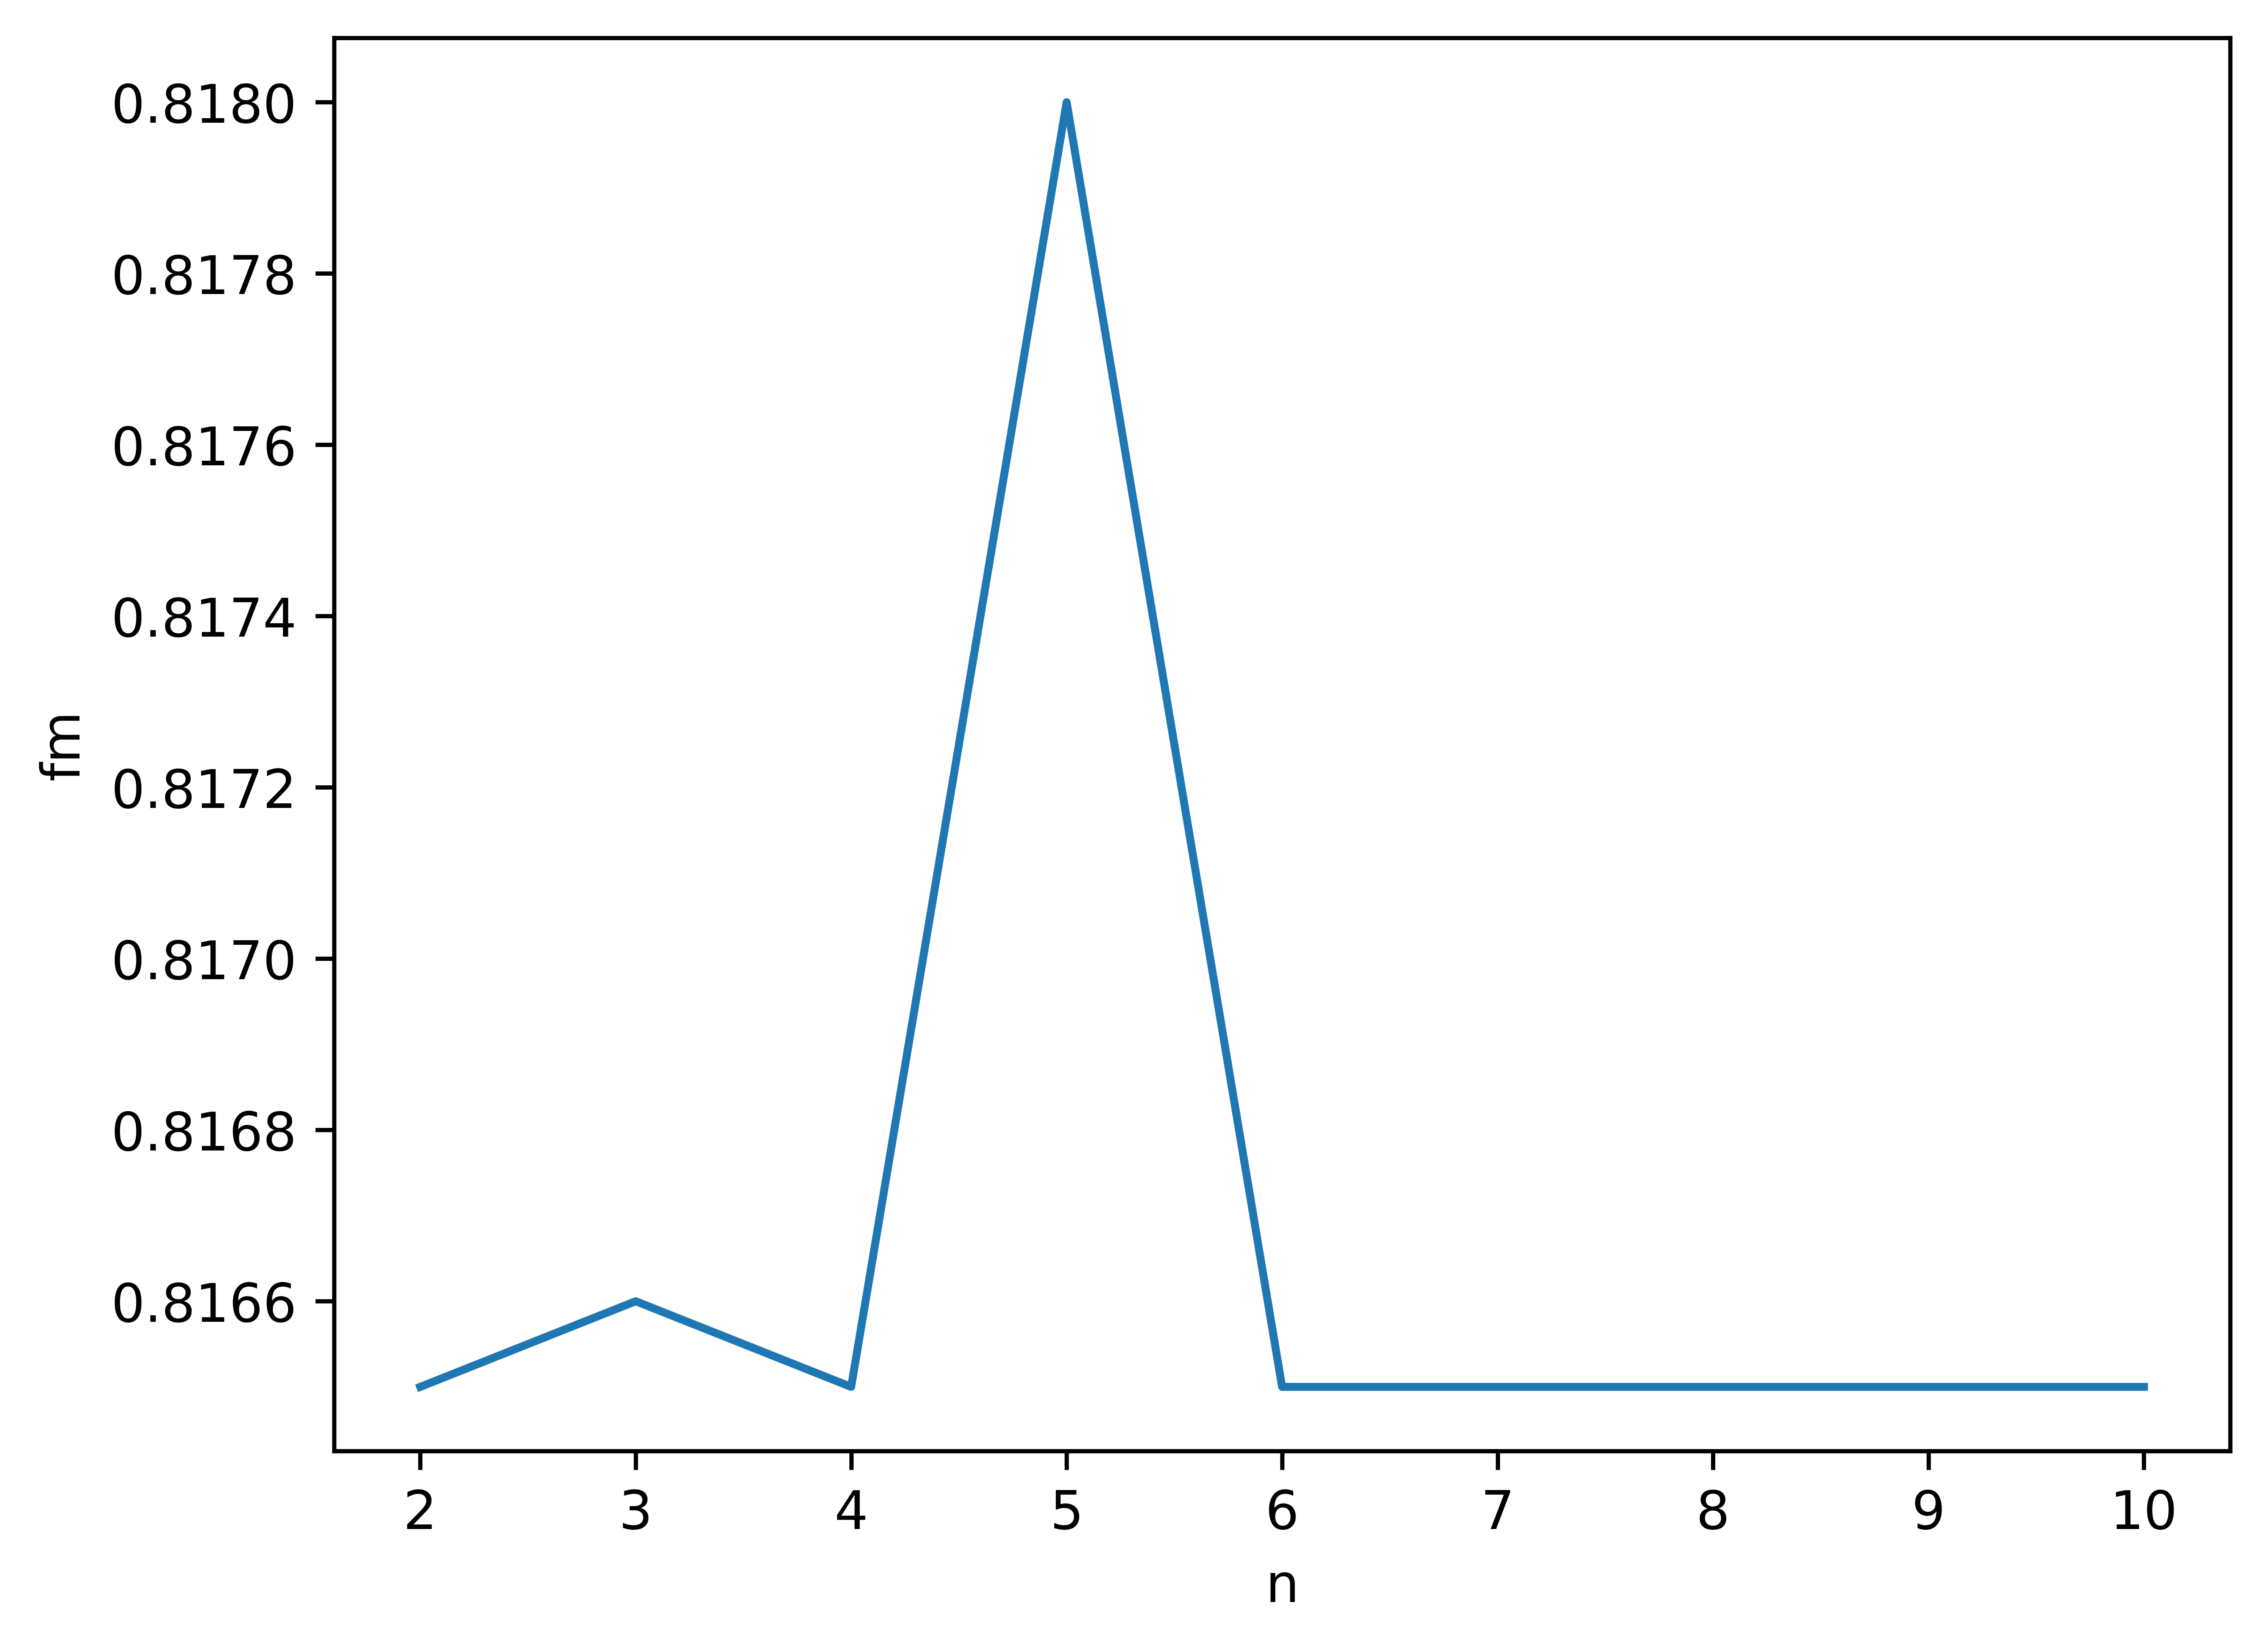

In [31]:
scat_n = []
scat_fm = []
for it in all_result:
    n, pred = it
    scat_n.append(n)
    scat_fm.append(round(fowlkes_mallows_score(y, pred), 4))

fig = plt.figure(dpi=1000)
plt.plot(scat_n, scat_fm)
plt.xlabel('n')
plt.ylabel('fm')
plt.savefig('fm.png') # TODO

## 四、与标准包的对比

In [33]:
std_model = KMeans(n_clusters=5, n_init=10)
std_model.fit(X)

KMeans(n_clusters=5, n_init=10)

In [34]:
std_result = std_model.labels_

fm = fowlkes_mallows_score(y, std_result)
ri = rand_score(y, std_result)

print(f"Fowlkes-Mallows Index (FM): {fm:.4f}")
print(f"Rand Index (RI): {ri:.2f}")

Fowlkes-Mallows Index (FM): 0.8167
Rand Index (RI): 0.67


## 五、大数据性能测试

In [35]:
fulldata = pd.read_csv('./dataset/kddcup.data.corrected', sep=',')

In [36]:
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome'
]
discrete_columns = [
    'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'
]
fulldata.columns = columns

LE = LabelEncoder()

big_X = fulldata.drop('outcome', axis=1)
for column in discrete_columns:
    big_X[column] = LE.fit_transform(big_X[column]).astype(np.float64)

In [37]:
now_model = KMeans(n_clusters=5, n_init=10)
now_model.fit(X)

KMeans(n_clusters=5, n_init=10)

In [38]:
now_my_model = MyKMeans(n_clusters=5, n_init=10)
now_my_model.fit(X)

In [ ]:
big_y = LE.fit_transform(fulldata['outcome']).astype(np.int32)
fm_std = fowlkes_mallows_score(big_y, now_model.labels_)
fm_my = fowlkes_mallows_score(big_y, now_my_model.labels_)

print(f"标准包 FM 指数: {fm_std:.4f}")
print(f"自实现 FM 指数: {fm_my:.4f}")

标准包 FM 指数: 0.6449
自实现 FM 指数: 0.7517
